# Import packages & functions

In [11]:
# Enable autoreload to automatically update changes in modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import MySrc
from MySrc.general_utilities import load_nwb, get_units_tables, get_trial_timing, compute_average_firing_rate, fetch_key_metrices, check_quality, save_figure # Import the function
from MySrc.plot_utilities import plot_neuron_general_metrices

# Load target data session

In [ ]:
# Set the path of the NWB file
filepath = "Z:\Kunpeng\Albus-S1_preproNWB\Albus-S1_TwoHands_psycho_NOpostchoice\exp2024-04-03-135625_prepro.nwb"# Open the file (dont forget to close it at the end "io.close()")
nwbfile = load_nwb(filepath)
units_tables, table_names = get_units_tables(nwbfile)
print(table_names)
trials_timings = get_trial_timing(nwbfile)
#trials_timings['start_times']

# prototype visulazation figure 1

In [35]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define time windows
# start_window = (-1, 6)  # Window around trial start (-1s to +6s)
# stop_window = (-6, 1)   # Window around trial stop (-6s to +1s)

# # Compute trial-averaged firing rates vs in window time using your function
# smoothed_firing_rate_start, time_bins_start = compute_average_firing_rate(unit_spike_times, start_times, window=start_window,smooth = True,bin_size = 0.02)
# smoothed_firing_rate_stop, time_bins_stop = compute_average_firing_rate(unit_spike_times, stop_times, window=stop_window,smooth = True,bin_size = 0.02)

# # Compute Inter-Spike Intervals (ISI) and remove zero/negative values
# ISIs = np.diff(unit_spike_times) * 1000  # Convert to ms
# ISIs = ISIs[ISIs > 0]  # ✅ Remove zero or negative values

# # Sample waveform data (Replace with actual data)
# x_offset = waveform_mean.shape[1] + 5  # Offset for horizontal separation

# # Compute trial-wise mean firing rate (for third row)
# trial_firing_rates = []
# trial_mean_amp = []
# for trial_idx in range(len(start_times)):
#     # Count total num of spiking and calculate FR
#     trial_spikes = unit_spike_times[(unit_spike_times >= start_times[trial_idx]) & (unit_spike_times <= stop_times[trial_idx])]
#     trial_duration = stop_times[trial_idx] - start_times[trial_idx]
#     trial_firing_rates.append(len(trial_spikes) / trial_duration if trial_duration > 0 else 0)

#     # fetch all spiking amps and calculate mea amp of that trial
#     trial_spikes_amps = abs(unit_spike_amp[(unit_spike_times >= start_times[trial_idx]) & (unit_spike_times <= stop_times[trial_idx])])
#     trial_mean_amp.append(np.mean(trial_spikes_amps))

# # Create 3×2 figure (Rows 1 & 2 with `sharey='row'`)
# fig, axes = plt.subplots(
#     ncols=4, 
#     nrows=3,  # ✅ Only create first 2 rows here
#     figsize=(12, 16), 
#     gridspec_kw={'width_ratios': [4, 4, 1,1], 'height_ratios': [2, 1, 1]},  # ✅ No row 3 yet!
#     sharey='row'
# )  

# ### **Row 1: Raster Plots & Mean Firing Rate**
# # Raster plot centered around trial start
# axes[0, 0].set_title("Raster Plot Centered Around Trial Start")
# for trial_idx, start_time in enumerate(start_times):
#     aligned_spikes = unit_spike_times - start_time
#     filtered_spikes = aligned_spikes[(aligned_spikes >= start_window[0]) & (aligned_spikes <= start_window[1])]
#     axes[0, 0].eventplot(filtered_spikes, lineoffsets=trial_idx, colors='black')

# axes[0, 0].axvline(0, color='red', linestyle='--', label="Trial Start")
# axes[0, 0].set_xlim(start_window)
# axes[0, 0].set_xlabel("Time (s) relative to trial start")
# axes[0, 0].set_ylabel("Trial Number")
# #axes[0, 0].legend()

# # Raster plot centered around trial stop
# axes[0, 1].set_title("Raster Plot Centered Around Trial Stop")
# for trial_idx, stop_time in enumerate(stop_times):
#     aligned_spikes = unit_spike_times - stop_time
#     filtered_spikes = aligned_spikes[(aligned_spikes >= stop_window[0]) & (aligned_spikes <= stop_window[1])]
#     axes[0, 1].eventplot(filtered_spikes, lineoffsets=trial_idx, colors='black')

# axes[0, 1].axvline(0, color='red', linestyle='--', label="Trial Stop")
# axes[0, 1].set_xlim(stop_window)
# axes[0, 1].set_xlabel("Time (s) relative to trial stop")
# axes[0, 1].set_ylabel("Trial Number")
# #axes[0, 1].legend()

# # Mean firing rate per trial (Row 1, Rightmost Panel)
# axes[0, 2].barh(range(len(trial_firing_rates)), trial_firing_rates, color='blue', height=1)
# axes[0, 2].set_title("Mean Firing Rate")
# axes[0, 2].set_xlabel("Firing Rate (Hz)")
# axes[0, 2].set_yticks([])

# # Mean firing rate per trial (Row 1, Rightmost Panel)
# axes[0, 3].barh(range(len(trial_mean_amp)), trial_mean_amp, color='blue', height=1)
# axes[0, 3].set_title("Mean Ampl")
# axes[0, 3].set_xlabel("abs.ampl")
# axes[0, 3].set_yticks([])

# ### **Row 2: Trial-Averaged Smoothed Activity (Now as Area Plot)**
# # Trial-averaged activity centered on trial start
# axes[1, 0].fill_between(time_bins_start[1:], smoothed_firing_rate_start, color='black', alpha=0.3)
# axes[1, 0].plot(time_bins_start[1:], smoothed_firing_rate_start, color='black',linewidth = 0.5)
# axes[1, 0].axvline(0, color='red', linestyle='--', label="Trial Start")
# axes[1, 0].set_xlim(start_window)
# axes[1, 0].set_xlabel("Time (s) relative to trial start")
# axes[1, 0].set_ylabel("Mean Firing Rate (Hz)")
# axes[1, 0].set_title("Trial-Averaged Activity (Start)")

# # Trial-averaged activity centered on trial stop
# axes[1, 1].fill_between(time_bins_stop[1:], smoothed_firing_rate_stop, color='black', alpha=0.3)
# axes[1, 1].plot(time_bins_stop[1:], smoothed_firing_rate_stop, color='black',linewidth = 0.5)
# axes[1, 1].axvline(0, color='red', linestyle='--', label="Trial Stop")
# axes[1, 1].set_xlim(stop_window)
# axes[1, 1].set_ylim([0,None])
# axes[1, 1].set_xlabel("Time (s) relative to trial stop")
# axes[1, 1].set_ylabel("Mean Firing Rate (Hz)")
# axes[1, 1].set_title("Trial-Averaged Activity (Stop)")

# # Remove rightmost column in row 2 (not needed)
# axes[1, 2].axis("off")
# axes[1, 3].axis("off")
# axes[2, 0].axis("off")
# axes[2, 1].axis("off")
# axes[2, 2].axis("off")
# axes[2, 3].axis("off")

# ### **Manually Create Row 3 (Independent Y-Axes)**
# # **Waveform Plot (1st column)**
# ax_waveform = fig.add_subplot(3, 4, 9)  # ✅ Insert new subplot manually
# ax_waveform.set_title("Mean Waveforms")
# for ch in range(waveform_mean.shape[0]):
#     x_values = np.arange(waveform_mean.shape[1]) + ch * x_offset  # Shift each waveform
#     ax_waveform.plot(x_values, waveform_mean[ch, :], label=f'Ch {ch+1}', color='black')

# ax_waveform.set_xlabel("Time (samples)")
# ax_waveform.set_ylabel("Amplitude")
# ax_waveform.grid(True, linestyle="--", alpha=0.5)

# # **ISI Histogram (2nd column)**
# ax_isi = fig.add_subplot(3, 4, 10)  # ✅ Insert new subplot manually
# ax_isi.set_title("ISI Histogram (Zoomed to 30ms)")
# ax_isi.hist(ISIs, bins=np.linspace(0, 30, 30), color='blue', alpha=0.7, edgecolor='black', log=False)
# ax_isi.axvline(2, color='red', linestyle="--", label="2ms Refractory Period")
# ax_isi.set_xlabel("Inter-Spike Interval (ms)")
# ax_isi.set_ylabel("counts")
# ax_isi.set_xlim([0,30])


# # **Empty panel for future use**
# ax_empty = fig.add_subplot(3, 3, 9)
# ax_empty.axis("off")

# # Extract neuron metrics
# fetched_metrices, metrices_names = fetch_key_metrices(units_tables, table_names, electrode_id, unit_id)

# # Define text position (adjust as needed)
# text_x = 0.71  # Adjust X position to fit inside the empty space
# text_y = 0.5  # Start from top of empty space
# line_spacing = (text_y-0.05) / len(metrices_names) if len(metrices_names) > 0 else 0.05  # Ensure proper spacing

# # Add each metric as a text annotation
# for i, met_name in enumerate(metrices_names):
#     metric_value = fetched_metrices[met_name]
#     text_line = f"{met_name} = {metric_value:.3f}" if isinstance(metric_value, (int, float)) else f"{met_name} = {metric_value}"
#     # Check quality of the metric
#     is_good_quality = check_quality(met_name, metric_value)
    
#     # Choose color based on quality check
#     text_color = "red" if not is_good_quality else "black"
    
#     # Display text with color coding
#     fig.text(text_x, text_y - i * line_spacing, text_line, fontsize=12, fontweight="bold", color=text_color, verticalalignment="top")

# # Define the title text using electrode name and unit ID
# grand_title = f"Neuron Metrics for Electrode: {table_names[electrode_id]}, Unit: {unit_id}"

# # Add the grand title to the entire figure
# fig.suptitle(grand_title, fontsize=16, fontweight="bold",y = 0.92)  # Adjust y to prevent overlap

# # Adjust layout for better spacing
# plt.tight_layout()
# # Show the plot
# plt.show()


# Example of plot neuron visualization figure 1

In [ ]:
unit_id = 6
electrode_id = 0
unit_spike_times = units_tables[table_names[electrode_id]]["spike_times"][unit_id]
waveform_mean = units_tables[table_names[electrode_id]]["waveform_mean"][unit_id]
unit_spike_amp = units_tables[table_names[electrode_id]]["spike_amplitudes"][unit_id]
start_times = trials_timings['start_times']
stop_times = trials_timings['stop_times']

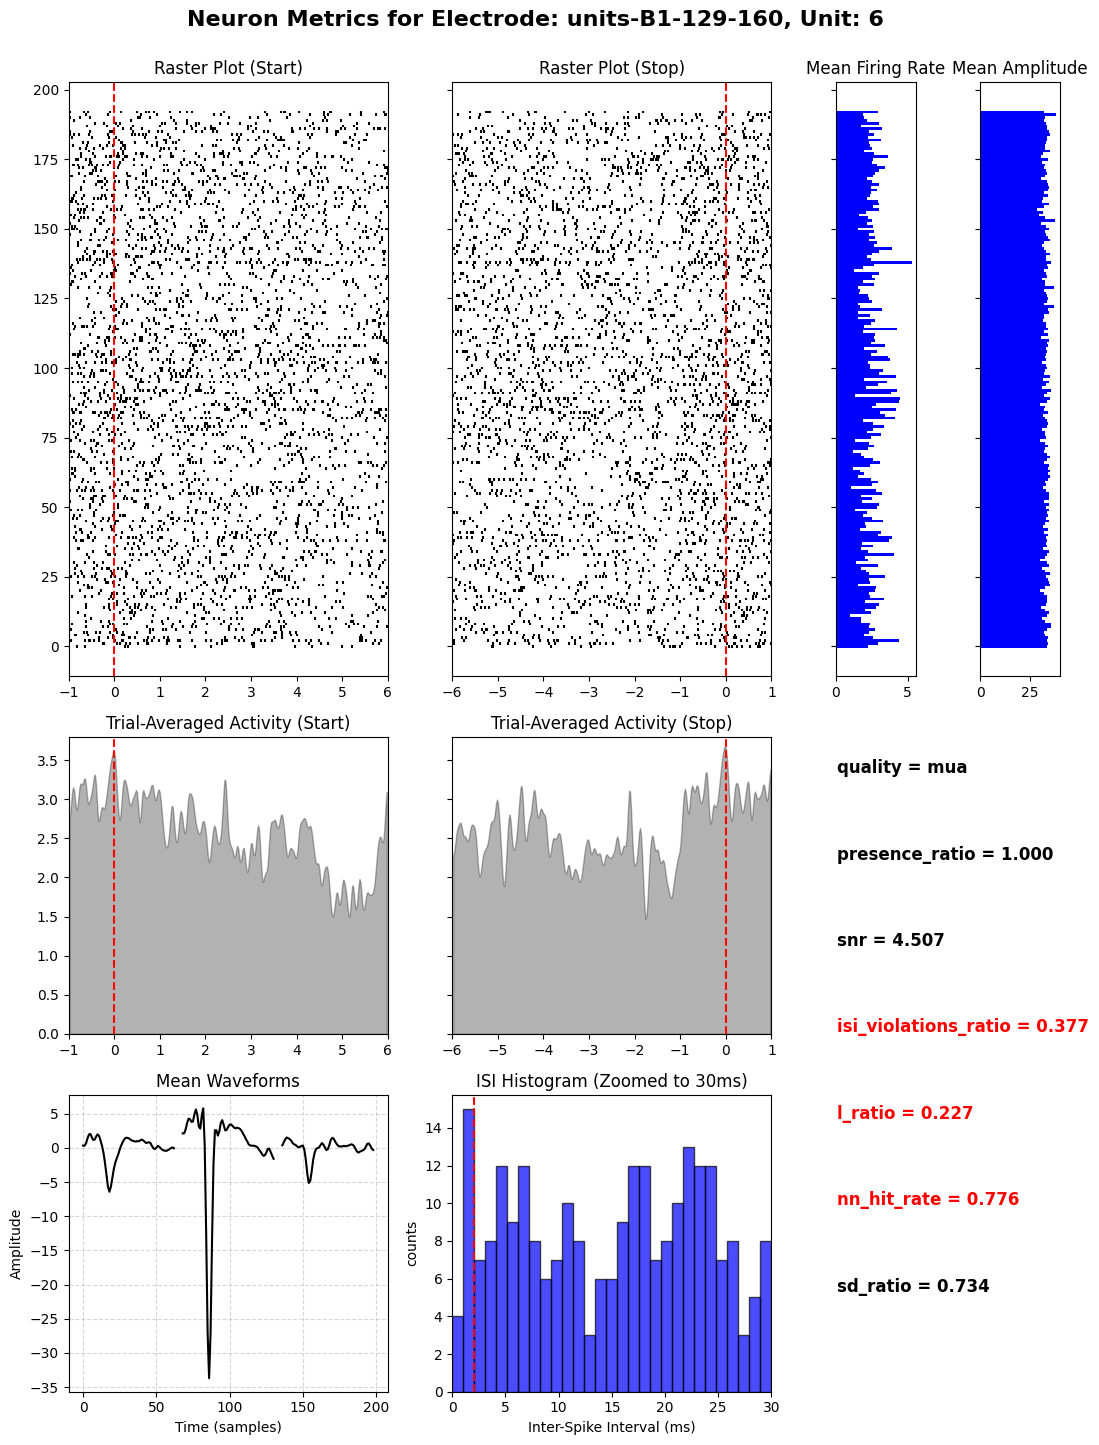

In [37]:
fig = plot_neuron_general_metrices(
    units_tables, table_names, electrode_id=0, unit_id=6, trials_timings=trials_timings, resize = 0.9)


In [41]:
save_figure(fig, ".jpg")  # Will save as "231203153045.jpg" (date+time)


✅ Figure saved at: d:\Documents\GitHub\NWB_visualization\notebooks\example_plots\250227143903.jpg


# prototype for neuron visualization figure 2

In [ ]:
unit_id = 6
electrode_id = 0
unit_spike_times = units_tables[table_names[electrode_id]]["spike_times"][unit_id]
waveform_mean = units_tables[table_names[electrode_id]]["waveform_mean"][unit_id]
unit_spike_amp = units_tables[table_names[electrode_id]]["spike_amplitudes"][unit_id]
start_times = trials_timings['start_times']
stop_times = trials_timings['stop_times']